### Training the ST RES NET with MITBIH / Apnea-ecg datasets

Sampling frequency in Apnea-ecg is 100 Hz, whereas in the MITBIH it is 360 Hz. Therefore the MITBIH dataset was downsampled using resample_signal and downsample_r_peaks_probability (customLib/preprocess.py).

In [1]:
import numpy as np
import torch
from customLib.vis import plot_ecg
from customLib.dataset import read_dataset
from customLib.config import apnea_ecg_path, mitbih_path
from models.models import ST_RES_NET

In [10]:
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(mitbih_path + "\\dataset", is_validation_set=True)

In [13]:
x_train = np.expand_dims(x_train, 1)[:8000]
y_train = np.expand_dims(y_train, 1)[:8000]

x_test = np.expand_dims(x_test, 1)[:2000]
y_test = np.expand_dims(y_test, 1)[:2000]

x_val = np.expand_dims(x_val, 1)[:1000]
y_val = np.expand_dims(y_val, 1)[:1000]

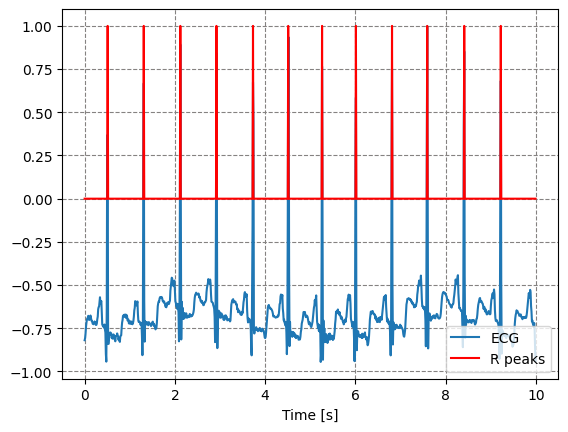

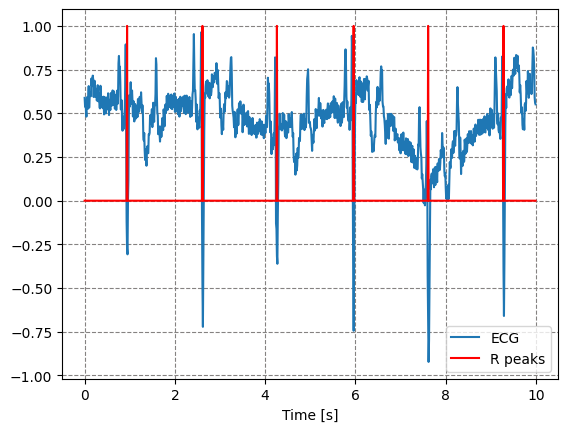

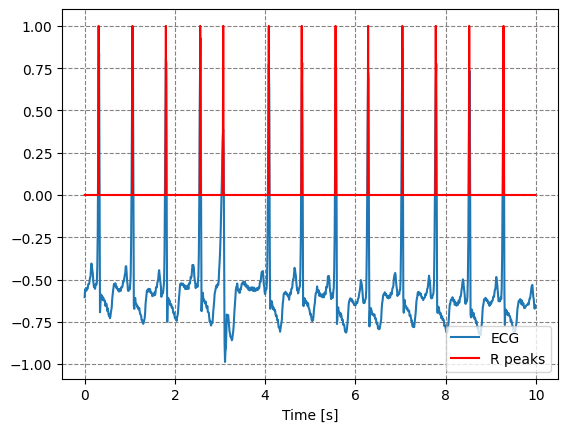

In [14]:
plot_ecg(x_train[100].flatten(), y_train[100].flatten(), 100)
plot_ecg(x_test[-1].flatten(), y_test[-1].flatten(), 100)
plot_ecg(x_val[-1].flatten(), y_val[-1].flatten(), 100)

In [2]:
model = ST_RES_NET(learning_rate=1e-4)

Training will be performed with: cuda:0


In [ ]:
model.train_model(x_train=x_train, y_train=y_train, epochs=10, x_val=x_val, y_val=y_val, batch_size=10)

In [21]:
torch.save(model.state_dict(), "./checkpoints/st_res_net.pt")

In [ ]:
model.test_model(x_test=x_test, y_test=y_test, plot=True)

### Testing on the PTB-XL dataset

In [3]:
model = ST_RES_NET(learning_rate=1e-4)
model.load_state_dict(torch.load("./checkpoints/st_res_net.pt"))

Training will be performed with: cuda:0


<All keys matched successfully>

In [4]:
from customLib.config import ptbxl_path
from customLib.load_ptbxl import load_ptbxl
from customLib.create_dataset import label_ecgs

In [5]:
ecgs_ptbxl = load_ptbxl(path=ptbxl_path, sampling_rate=100, files_num="all") # loading only ECGs labeled as normal
x, y = label_ecgs(ecgs=ecgs_ptbxl, sampling_rate=100) # self labeling the ECGs

100%|██████████| 9514/9514 [00:29<00:00, 321.38it/s]


Total ECGs: 9514


100%|██████████| 9514/9514 [00:09<00:00, 1015.43it/s]


In [6]:
x_test = np.expand_dims(x, 1)[:2000]
y_test = np.expand_dims(y, 1)[:2000]
print("X test shape: ", x_test.shape)
print("Y test shape: ", y_test.shape)

X test shape:  (2000, 1, 1000)
Y test shape:  (2000, 1, 1000)


  0%|          | 0/200 [00:00<?, ?it/s]

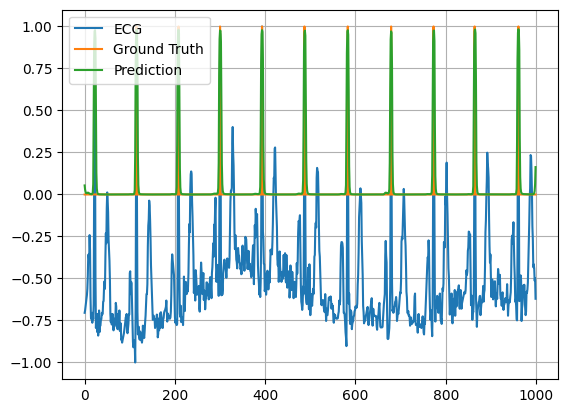

  8%|▊         | 16/200 [00:00<00:06, 27.44it/s]

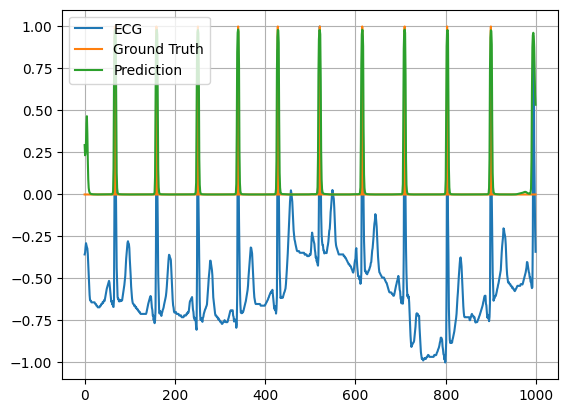

 19%|█▉        | 38/200 [00:01<00:04, 39.98it/s]

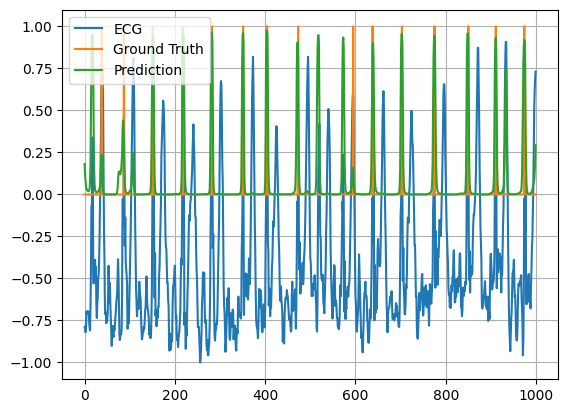

 28%|██▊       | 55/200 [00:01<00:03, 41.78it/s]

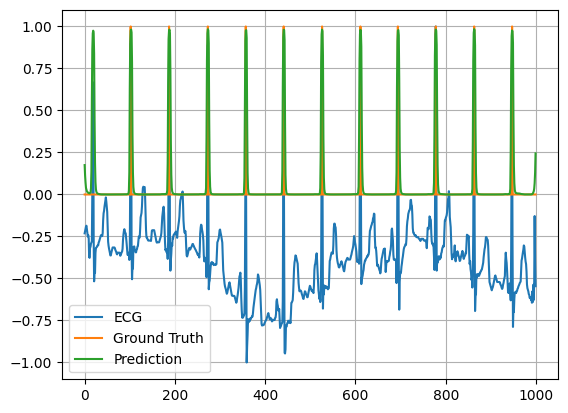

 39%|███▉      | 78/200 [00:02<00:02, 44.99it/s]

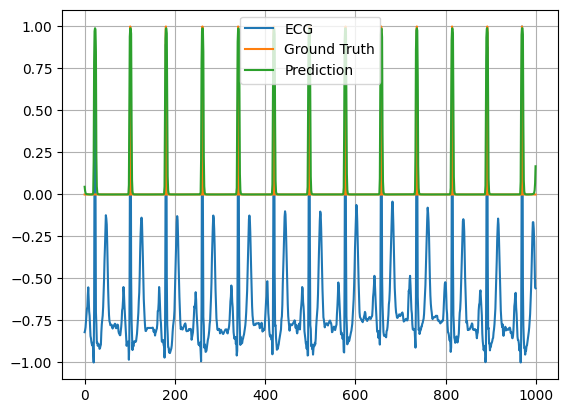

 48%|████▊     | 95/200 [00:02<00:02, 45.42it/s]

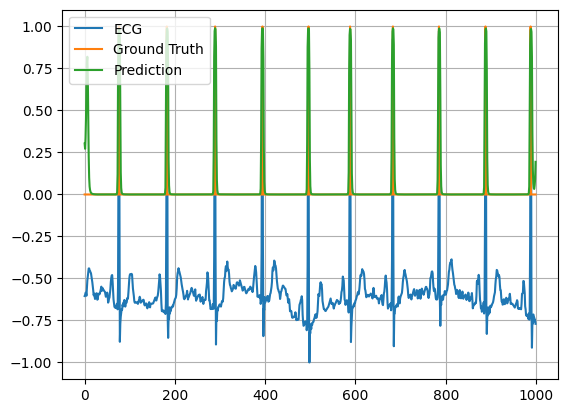

 60%|██████    | 120/200 [00:03<00:01, 49.84it/s]

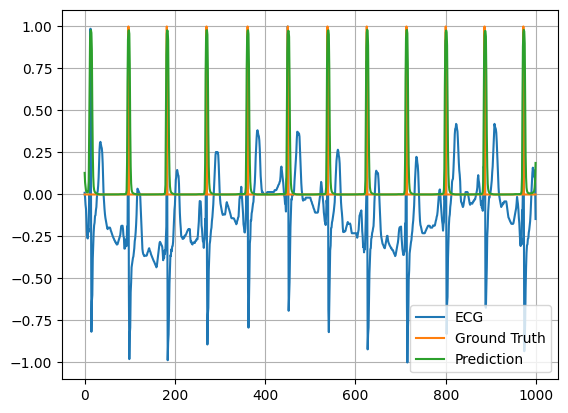

 69%|██████▉   | 138/200 [00:03<00:01, 44.42it/s]

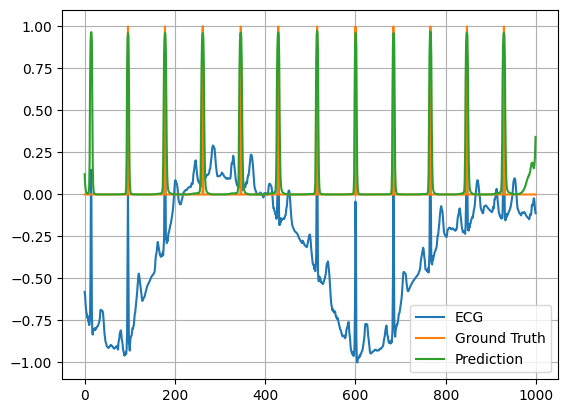

 78%|███████▊  | 155/200 [00:04<00:01, 44.51it/s]

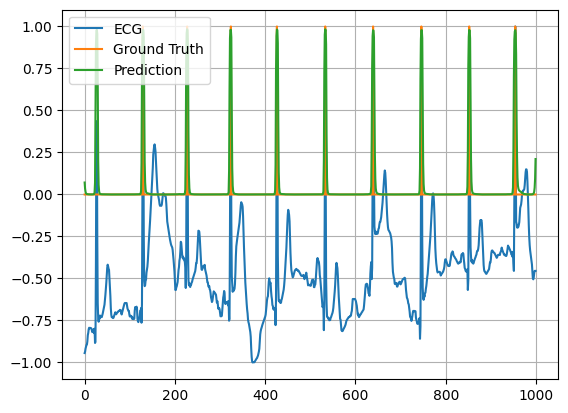

 89%|████████▉ | 178/200 [00:04<00:00, 45.97it/s]

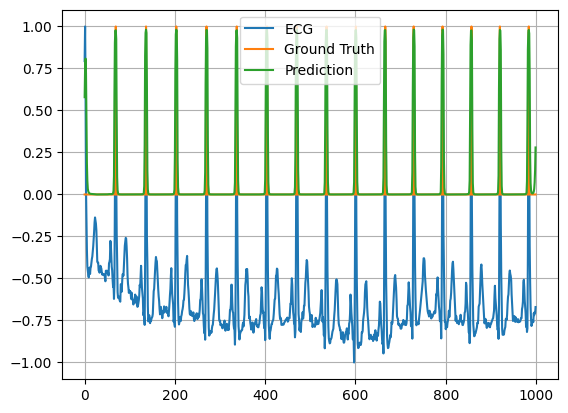

100%|██████████| 200/200 [00:05<00:00, 36.96it/s]



Test Loss: 0.0022
Test Accuracy: 99.04586 %
Test F1 Score: 0.29887
Test TPR: 0.99046
Test FPR: 0.05334



In [7]:
model.test_model(x_test, y_test, plot=True)

### Notes
The ST_RES_NET output layer is Conv1D layer instead of the Dense layer, proposed in the original paper. The number of filters, kernel size, and strides in the Conv1D layer were adjusted to match the number of outpus samples in the original signal.

The Linear / Dense layer resulted in a poor performance during training on both MITBIH and Apnea-ecg datasets. I did not investigate further this issue.

Also the ST_RES_NET model's performance has improved when the loss function has been changed from BCELoss to WeightedBCELoss with class weights. The class weights are calculated based on the distribution of the labels.